### 0.0 Import modules

Here, we'll be using Scikit-learn, Numpy, and Pandas for the data-driven work. 
Seaborn is used for an aesthetic touch to some plots, alongside with Matplotlib.

In [23]:
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr

import seaborn as sns

### 0.1 Setup Matplotlib

In [2]:
#Matplotlib Settings
matplotlib.use('TkAgg')
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

#Create custom colormap for decision boundaries
colors = [(0, 0.37, 0.63), (0.863, 0.078, 0.235), (1, 0.84, 0)]  # R -> G -> B
n_bins = 3
cmap_name = 'my_list'
cmap = clr.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

### 1.0 Load Data

First we load the data generated from 0D adiabatic reactors with the n-dodecane mechanism from Yao et. al., Fuel (2017).

In [3]:
data = pd.read_csv('./data/adiabatic_1000_sk54.csv') 
X = data[['T_0', 'X_fu']]
y = data['Label']
T_ad_K = data['T_ad_K']
CH2O = data['CH2O']

Then we plot the temperature and formaldehyde, which defines the low and high temperature ignition behavior in the 3 three classes (low T, high T, no ignition) following the definition by Ju et. al. (2019) in their review paper on cool flames.

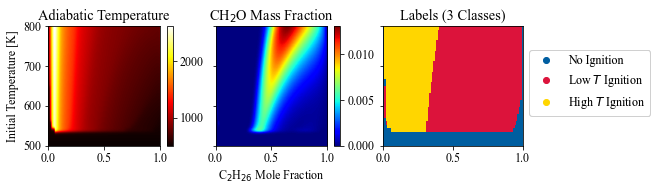

In [79]:
fig, axs = plt.subplots(1, 3, figsize=(8.5, 2.2), sharey=True)

image = axs[0].imshow(np.flipud(np.array(T_ad_K).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'gaussian',cmap = 'hot')
axs[0].set_title('Adiabatic Temperature')
axs[0].set_ylabel("Initial Temperature [K]")
fig.colorbar(image, ax=axs[0])

image=axs[1].imshow(np.flipud(np.array(CH2O).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'gaussian',cmap = 'jet')
axs[1].set_title(r'CH$_2$O Mass Fraction')
axs[1].set_xlabel(r"C$_2$H$_{26}$ Mole Fraction")
fig.colorbar(image, ax=axs[1])


axs[2].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
axs[2].set_title('Labels (3 Classes)')

my_scatter = axs[2].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[2].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),
                    loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[2].add_artist(legend1)

### 1.1 Split into Train, Validation, and Test Sets

A common practice in supervised learning involves splitting learning datasets into a training, validation, and testing set. Here, we split the learning data into a 60:20:20 split.

In [5]:
seed = 42 #Initialize seed for random components in ML algorithms

X_train, X_test_dev, y_train, y_test_dev = train_test_split(X, y, test_size=0.4, random_state=seed,stratify=y)

X_dev, X_test,  y_dev, y_test= train_test_split(X_test_dev, y_test_dev, test_size=0.5, random_state=seed,stratify=y_test_dev)

Then we plot the split dataset.

Train = 60.0: Dev = 20.0: Test = 20.0


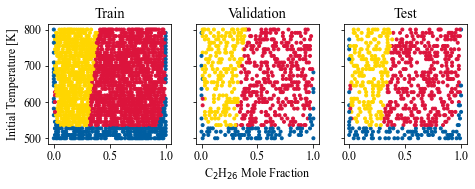

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.2), sharey=True)

axs[0].scatter(X_train.X_fu,X_train.T_0,c=y_train,cmap=cmap,marker='.')
axs[0].set_ylabel("Initial Temperature [K]")
axs[0].set_title('Train')

axs[1].scatter(X_dev.X_fu,X_dev.T_0,c=y_dev,cmap=cmap,marker='.')
axs[1].set_xlabel(r"C$_2$H$_{26}$ Mole Fraction")
axs[1].set_title('Validation')

axs[2].scatter(X_test.X_fu,X_test.T_0,c=y_test,cmap=cmap,marker='.')
axs[2].set_title('Test')

print("Train = "+str(len(y_train)/len(y)*100) 
      + ": Dev = "+str(len(y_dev)/len(y)*100)
      +": Test = "+str(len(y_test)/len(y)*100))

Here we normalize the training and validation set with a preprocessing function. This makes training easier for NNs during gradient descent as all dimensions of the optimization manifold will be around the same scales.

In [17]:
X_dev_scaled = preprocessing.scale(X_dev)
X_decision_boundary =  preprocessing.scale(X)
X_test_scaled = preprocessing.scale(X_test)

### 2.0 Hyperparameter Search: SVC

Now that we have a validation set, we can optimize the ML hyperparameters for our problem. We focus on SVM as there are only 2 main hyperparameters for an RBF SVM. This makes the demonstration of grid search feasible. Within RBF SVM, $C$ is associated with the cost factor of the soft margin, while $\gamma$ is related to the variance of the data. For more info on the RBF kernel, please see: https://www.cs.toronto.edu/~duvenaud/cookbook/

We first define our grid of interest, here we range between 10e-2 to 10e+13 for $C$; 10e-9 to 10e+13 for $\gamma$. These ranges might require a bit of trial-and-error for fine-tuning

In [18]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

Next, we define our cross-validation split. Here we use a 3-fold cross-validation. This splits the validation set further into 3 smaller sets (https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation). Hyperparameter optmization will then be tested on each set. The performance from each fold will then be averaged.

In [19]:
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=seed)

Then, we perform grid search on the SVM and print the optimum hyperparameter.

In [20]:
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_dev_scaled, y_dev)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10000.0, 'gamma': 0.1} with a score of 0.98


Next, we plot a countour plot of validation accuracy as function of $C$ and $\gamma$.

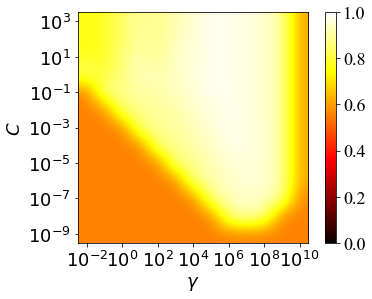

In [21]:
# Draw heatmap of the validation accuracy as a function of gamma and C
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))

plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='bicubic', cmap=plt.cm.hot,origin='lower')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$C$')
plt.colorbar()
plt.clim([0,1])
fmt_C = [r'$10^{%d}$' % np.log10(i) for i in C_range.tolist()]
fmt_gamma = [r'$10^{%d}$' % np.log10(i) for i in gamma_range.tolist()]
plt.xticks(np.arange(len(gamma_range))[::2], fmt_C[::2],)
plt.yticks(np.arange(len(C_range))[::2], fmt_gamma[::2])
# plt.title('SVM Validation Accuracy')
plt.savefig("./figs/svm_validation.pdf", bbox_inches="tight")

To further visualize the importance of hyperparameter optimization, we fit the SVM with the range of hyperparameters, including the optimum hyperparameter.

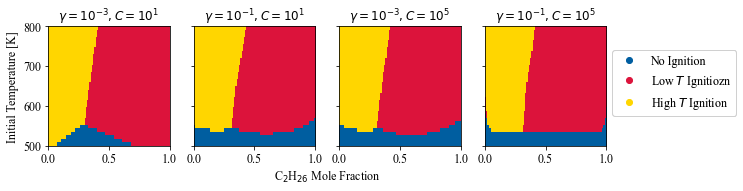

In [81]:
# Fit SVM for 4 different hyperparameters
C_2d_range = [1e1, 1e5]
gamma_2d_range = [1e-3, 1e-1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_dev_scaled, y_dev)
        classifiers.append((C, gamma, clf))

# Visualization of parameter effects
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
fig, axs = plt.subplots(1, 4, figsize=(10, 2.2), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"C$_2$H$_{26}$ Mole Fraction")
axs[0].set_ylabel("Initial Temperature [K]")
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # visualize decision function for these parameters
    axs[k].set_title(r"$\gamma=10^{%d} , C=10^%d$" % (np.log10(gamma), np.log10(C)),
              size='medium')
    axs[k].imshow(np.flipud(clf.predict(X_decision_boundary).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
    # visualize parameter's effect on decision function

my_scatter = axs[3].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[3].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignitiozn",r"High $T$ Ignition"]),
                    loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[3].add_artist(legend1)

These plots demonstrate the importance of finding the right hyperparameters in an ML problem. Often, poor performance can be attributed to sub-optimal hyperparameters.

### 2.1 Hyperparameter Search: NN

We define our Feed Forward Neural Network. We use ReLU in our hidden units for its fast convergence properties. Adam (https://arxiv.org/pdf/1412.6980.pdf) is good robust solver

In [25]:
model = MLPClassifier(activation='relu', 
                    solver='adam', 
                    max_iter=500, 
                    shuffle=True, 
                    random_state=seed, 
                    tol=0.0001, 
                    n_iter_no_change=10)

Next we create a 7-dimensional hyperparameter search space, over a broad range of values.

In [26]:
hidden_layer_sizes =[(2,2),(2,2,2)
                     ,(5,5),(5,5,5)
                    ,(10,10),(10,10,10)
                    ,(2,5),(2,5,10)
                    ,(2,10),(2,10,5)
                    ,(5,2),(5,2,10)
                     ,(5,10),(5,10,2)
                    ,(10,2),(10,5,2)
                    ,(10,5),(10,2,5)] 
alpha = [0.5,0.2,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
batch_size=[1,5,10,20,50,100]
learning_rate_init=[1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
beta_1=[0.9,0.99,0.999]
beta_2=[0.9,0.99,0.999]
epsilon=[1e-5,1e-6,1e-7,1e-8,1e-9,1e-10]

# Create hyperparameter options
hyperparameters = dict(hidden_layer_sizes = hidden_layer_sizes, 
                        alpha = alpha,
                        batch_size = batch_size,
                        learning_rate_init = learning_rate_init,
                        beta_1 = beta_1,
                        beta_2 = beta_2,
                        epsilon = epsilon)

Since a complete grid search is very computationally expensive, we perform a random search over this hyperparameter space. In order to speed things up, we specify the use of distribute this job to 8 CPU threads.

In [27]:
clf = RandomizedSearchCV(model, hyperparameters,n_iter=20, cv=3, verbose=1,n_jobs = 8)
best_model = clf.fit(X_dev_scaled, y_dev)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [146]:
print(best_model.best_params_)

{'learning_rate_init': 0.001,
 'hidden_layer_sizes': (10, 2),
 'epsilon': 1e-08,
 'beta_2': 0.99,
 'beta_1': 0.9,
 'batch_size': 20,
 'alpha': 1e-06}

Since our first hyperparameter search was performed over a broad range, we perform another random search over a smaller space, close to the parameters found in the first search:

In [147]:
hidden_layer_sizes =[(10,10),(10,10,10)
                    ,(10,2),(10,5,2)
                    ,(10,5),(10,2,5)] 
alpha = [1e-5,1e-6,1e-7]
batch_size=[10,20,50]
learning_rate_init=[1e-2,1e-3,1e-4]
beta_1=[0.9,0.95,0.99]
beta_2=[0.99,0.995,0.999]
epsilon=[1e-5,1e-6,1e-7]


# Create hyperparameter options
hyperparameters = dict(hidden_layer_sizes = hidden_layer_sizes, 
                        alpha = alpha,
                        batch_size = batch_size,
                        learning_rate_init = learning_rate_init,
                        beta_1 = beta_1,
                        beta_2 = beta_2,
                        epsilon = epsilon)

clf = RandomizedSearchCV(model, hyperparameters,n_iter=20, cv=3, verbose=1,n_jobs = 8)
best_model = clf.fit(X_dev_scaled, y_dev)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/wtchung/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [148]:
best_model.best_params_

{'learning_rate_init': 0.001,
 'hidden_layer_sizes': (10, 10),
 'epsilon': 1e-07,
 'beta_2': 0.995,
 'beta_1': 0.99,
 'batch_size': 20,
 'alpha': 1e-05}

Now we compare the training loss over time two optimized neural networks.

/Users/wtchung/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/wtchung/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


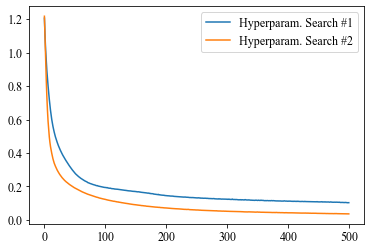

In [33]:
mlp_list = []
y_mlp_decision_boundary_list = []
y_mlp_test_list = []
y_mlp_train_list = []


mlp_list.append(MLPClassifier(activation='relu', 
                                solver='adam', 
                                max_iter=500, 
                                shuffle=True, 
                                random_state=seed, 
                                tol=0.0001, 
                                n_iter_no_change=10
                              ,hidden_layer_sizes=(10,2)
                              ,learning_rate_init=1e-3
                              ,epsilon = 1e-8
                              ,beta_2= 0.99
                              ,beta_1= 0.9
                              ,batch_size= 20
                              ,alpha= 1e-06).fit(X_dev_scaled, y_dev))
mlp_list.append(MLPClassifier(activation='relu', 
                                solver='adam', 
                                max_iter=500, 
                                shuffle=True, 
                                random_state=seed, 
                                tol=0.0001, 
                                n_iter_no_change=10
                          ,hidden_layer_sizes=(10,10)
                          ,learning_rate_init=1e-3
                          ,epsilon = 1e-7
                          ,beta_2= 0.995
                          ,beta_1= 0.99
                          ,batch_size= 20
                          ,alpha= 1e-05).fit(X_dev_scaled, y_dev))
    
i=0
for mlp in mlp_list:
    plt.plot(mlp.loss_curve_,label="Hyperparam. Search #"+str(i+1))
    i = i+1
    
plt.legend()


Since search #2 demonstrated a better convergece, this shows the importance of iteratively tuning the hyperparameters in NNs.

### 2.2 Hyperparameter search: Logistic regression

We repeat hyperparameter search for logistic regression, which can be done with grid search

In [41]:
C_range = [1e-2,1e-1,1,10,1e2,1e3,1e4]
param_grid = dict(C=C_range)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=seed)
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv)
grid.fit(X_dev_scaled, y_dev)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1000.0} with a score of 0.88


### 2.3 Hyperparameter search: Decision Tree

Again for decision trees, which can be done with grid search

In [114]:
min_samples_split_range = [2,5,10,20,50,100]
param_grid = dict(min_samples_split=min_samples_split_range)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=seed)
grid = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), param_grid=param_grid, cv=cv)
grid.fit(X_dev_scaled, y_dev)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'min_samples_split': 2} with a score of 0.97


### 2.4 Hyperparameter search: Random Forests

And finally for random forests, which can be done with grid search

In [139]:
min_samples_split_range = [2,5,10,20,50,100]
n_estimators_range = [2,5,10,20,50,100,200]

param_grid = dict(min_samples_split=min_samples_split_range,n_estimators=n_estimators_range)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=seed)
grid = GridSearchCV(RandomForestClassifier(criterion='entropy'), param_grid=param_grid, cv=cv)
grid.fit(X_dev_scaled, y_dev)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'min_samples_split': 2, 'n_estimators': 20} with a score of 0.98


### 3.0 Benchmarking Classifiers 

Now that we've found good hyperparameters for each ML algorithm, we can now compare the accuracy of the different methods.

We start by initializing the different proportions of training data used to train our ML algorithms.

In [35]:
train_size_list=[0.01,0.1,0.15,0.2,0.25,0.3,0.5,0.99]

Then we train and test all ML algorithms. Here we use the accuracy score (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) as performance metric.

In [390]:
logReg_i_list = []
dt_i_list = []
rf_i_list = []
mlp_i_list = []
svc_i_list = []

logReg_traintime_list = []
dt_traintime_list = []
rf_traintime_list = []
mlp_traintime_list = []
svc_traintime_list = []

logReg_testtime_list = []
dt_testtime_list = []
rf_testtime_list = []
mlp_testtime_list = []
svc_testtime_list = []

tmp_list = []

for train_size in train_size_list:
    X_train_i, Xtmp, y_train_i, ytmp = train_test_split(X_train, y_train, test_size=1.0-train_size, random_state=seed,stratify=y_train)

    X_scaled_i = preprocessing.scale(X_train_i)
    
    logReg = LogisticRegression(random_state=seed, C = 1000).fit(X_scaled_i, y_train_i)
    dt = DecisionTreeClassifier(random_state=seed,criterion = 'entropy').fit(X_scaled_i, y_train_i)
    rf = RandomForestClassifier(random_state=seed,n_estimators = 20,criterion = 'entropy').fit(X_scaled_i, y_train_i)    
    mlp = MLPClassifier(activation='relu', solver='adam', max_iter=1000, shuffle=True, random_state=seed, tol=0.0001, n_iter_no_change=10,hidden_layer_sizes=(10,10),learning_rate_init=1e-3,epsilon = 1e-7,beta_2= 0.995,beta_1= 0.99,batch_size= 20,alpha= 1e-05).fit(X_scaled_i, y_train_i)
    
    svc = SVC(gamma=0.1, C = 1e5, tol = 1e-4, kernel = 'rbf').fit(X_scaled_i, y_train_i)
    
    y_logReg_i = logReg.predict(X_test_scaled)
    y_dt_i = dt.predict(X_test_scaled)
    y_rf_i = rf.predict(X_test_scaled)
    y_mlp_i = mlp.predict(X_test_scaled)
    y_svc_i = svc.predict(X_test_scaled)

    logReg_i_list.append(metrics.accuracy_score(y_test,y_logReg_i))
    dt_i_list.append(metrics.accuracy_score(y_test,y_dt_i))
    rf_i_list.append(metrics.accuracy_score(y_test,y_rf_i))
    mlp_i_list.append(metrics.accuracy_score(y_test,y_mlp_i))
    svc_i_list.append(metrics.accuracy_score(y_test,y_svc_i))

Next we plot the test accuracy as a function of learning data fraction. Note that 100% of the training data is equivalent to 60% of the learning data, due to our data split performed in Section 1.1.

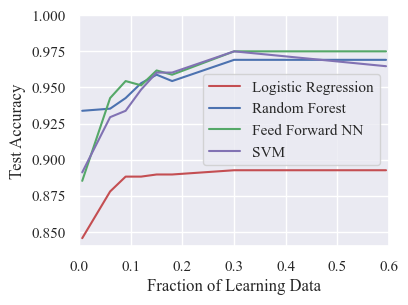

In [501]:
sns.set(style="darkgrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

plt.plot(np.array(train_size_list)*0.6,logReg_i_list,'r',label='Logistic Regression')

plt.plot(np.array(train_size_list)*0.6,rf_i_list,'b',label='Random Forest')

plt.plot(np.array(train_size_list)*0.6,mlp_i_list,'g',label='Feed Forward NN')

plt.plot(np.array(train_size_list)*0.6,svc_i_list,'m',label='SVM')

# ax.set_xscale('log')

plt.xlim([0,0.6])
plt.ylim([0.84,1])
# plt.xticks([0.01,0.2,0.4,0.6,0.8,1])

plt.legend(loc=[0.4,0.35])
plt.ylabel('Test Accuracy')
plt.xlabel('Fraction of Learning Data')
# plt.ylim([0,0])
fig.savefig("./figs/clf_accuracy.pdf", format='pdf', bbox_inches="tight")

Here we see that most algorithms (except Logistic Regression) converge around accuracy of 0.97. NNs generally perform best when given a large amount of data.

Next we compare computational cost during (training and predicting/inference) of the ML algorithms.

In [105]:
logReg_traintime_list = []
dt_traintime_list = []
rf_traintime_list = []
mlp_traintime_list = []
svc_traintime_list = []

logReg_testtime_list = []
dt_testtime_list = []
rf_testtime_list = []
mlp_testtime_list = []
svc_testtime_list = []

tmp_list = []
#Stratify to allow class-imbalance

X_scaled = preprocessing.scale(X_train)

my_time = %timeit -n 1 -r 3 -o  LogisticRegression(C = 1000).fit(X_scaled_i, y_train_i)
logReg_traintime = my_time.best

my_time = %timeit -n 1 -r 3 -o DecisionTreeClassifier(criterion = 'entropy').fit(X_scaled_i, y_train_i)
dt_traintime = my_time.best

my_time = %timeit -n 1 -r 3 -o RandomForestClassifier(n_estimators = 20,criterion = 'entropy').fit(X_scaled_i, y_train_i)
rf_traintime = my_time.best

my_time = %timeit -n 1 -r 3 -o MLPClassifier(activation='relu', solver='adam', max_iter=1000, shuffle=True, tol=0.0001, n_iter_no_change=10,hidden_layer_sizes=(10,10),learning_rate_init=1e-3,epsilon = 1e-7,beta_2= 0.995,beta_1= 0.99,batch_size= 20,alpha= 1e-05).fit(X_scaled_i, y_train_i)
mlp_traintime = my_time.best

my_time = %timeit -n 1 -r 3 -o SVC(gamma=0.1, C = 1e5, tol = 1e-4, kernel = 'rbf').fit(X_scaled_i, y_train_i)
svc_traintime = my_time.best 

logReg = LogisticRegression(C = 1000).fit(X_scaled_i, y_train_i)
dt = DecisionTreeClassifier(criterion = 'entropy').fit(X_scaled_i, y_train_i)
rf = RandomForestClassifier(n_estimators = 20,criterion = 'entropy').fit(X_scaled_i, y_train_i)    
mlp = MLPClassifier(activation='relu', solver='adam', max_iter=1000, shuffle=True, tol=0.0001, n_iter_no_change=10,hidden_layer_sizes=(10,10),learning_rate_init=1e-3,epsilon = 1e-7,beta_2= 0.995,beta_1= 0.99,batch_size= 20,alpha= 1e-05).fit(X_scaled_i, y_train_i)

svc = SVC(gamma=0.1, C = 1e5, tol = 1e-4, kernel = 'rbf').fit(X_scaled_i, y_train_i)

my_time = %timeit -n 1 -r 3 -o logReg.predict(X_test_scaled)
logReg_testtime = my_time.best 
my_time = %timeit -n 1 -r 3 -o dt.predict(X_test_scaled)
dt_testtime= my_time.best
my_time = %timeit -n 1 -r 3 -o rf.predict(X_test_scaled)
rf_testtime = my_time.best
my_time = %timeit -n 1 -r 3 -o mlp.predict(X_test_scaled)
mlp_testtime = my_time.best
my_time = %timeit -n 1 -r 3 -o svc.predict(X_test_scaled)
svc_testtime = my_time.best

13.5 ms ± 397 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.48 ms ± 233 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
33.2 ms ± 129 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
14.4 s ± 16 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
34.3 ms ± 387 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
146 µs ± 54.8 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
241 µs ± 107 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
2.94 ms ± 262 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
519 µs ± 154 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
866 µs ± 110 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


Let's plot the cost in a bar chart.

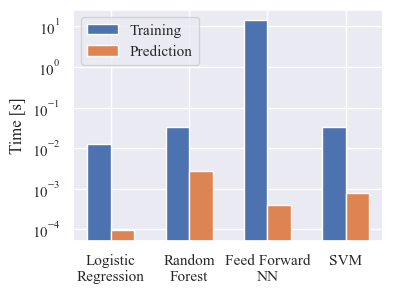

In [520]:
sns.set(style="darkgrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

columns = ['Logistic\nRegression', 'Random\nForest', 'Feed Forward\nNN','SVM']
test_time_list = [logReg_testtime,rf_testtime,mlp_testtime,svc_testtime]
test_index = np.arange(len(columns)) + 0.15

train_time_list = [logReg_traintime,rf_traintime,mlp_traintime,svc_traintime]
train_index = np.arange(len(columns)) - 0.15

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

plt.bar(train_index,train_time_list,log=True,width = 0.3,label='Training')
plt.bar(test_index,test_time_list,log=True,width = 0.3,label = 'Prediction')
plt.xticks(train_index+0.15, columns)
plt.ylabel("Time [s]")
plt.legend(loc="upper left")
fig.savefig("./figs/clf_timing.pdf", format='pdf', bbox_inches="tight")

NNs are accurate, but can be expensive to train.

### 3.1 Visualize Decision Boundaries: Setup

Let's visualize the predictions of ML algorithms, when trained with different sizes of data.

First, we switch back to matplotlib from seaborn.

In [36]:
%matplotlib inline 
matplotlib.style.use('default') 
#Setup figure
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

We visualize predicitions from training with 2%, 20 and 60% of the learning data.

In [37]:
X_train2, X_train58, y_train2, y_train58 = train_test_split(X_train, y_train, test_size=0.967, random_state=seed,stratify=y_train)
X_train20, X_train40, y_train20, y_train40 = train_test_split(X_train, y_train, test_size=0.667, random_state=seed,stratify=y_train)

X_scaled2 = preprocessing.scale(X_train2)
X_scaled20 = preprocessing.scale(X_train20)
X_scaled = preprocessing.scale(X_train)
X_train_list = [X_scaled2, X_scaled20,X_scaled] 
y_train_list = [y_train2, y_train20,y_train] 

### 3.2 Visualize Decision Boundaries: Logistic Regression

We train and test logistic regression.

In [39]:
logReg_list = []
y_logReg_decision_boundary_list = []
y_logReg_test_list = []
y_logReg_train_list = []
for i in range(len(X_train_list)):
    logReg_list.append(LogisticRegression(random_state=seed, C = 1000).fit(X_train_list[i], y_train_list[i]))
    y_logReg_decision_boundary_list.append(logReg_list[i].predict(X_decision_boundary))
    y_logReg_test_list.append(logReg_list[i].predict(X_test_scaled))
    y_logReg_train_list.append(logReg_list[i].predict(X_train_list[i]))

Now we compare predictions with the labels.

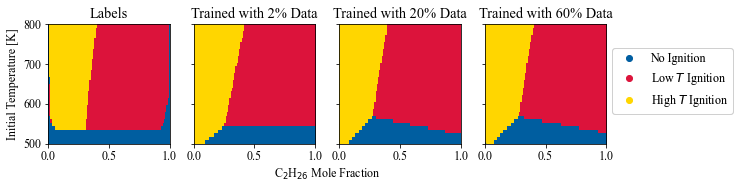

In [82]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2.2), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"C$_2$H$_{26}$ Mole Fraction")
axs[0].set_ylabel("Initial Temperature [K]")

#Plot figurex
axs[0].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
for i in range(len(X_train_list)):
    axs[i+1].imshow(np.flipud(np.array(y_logReg_decision_boundary_list[i]).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)

axs[0].set_title("Labels")
axs[1].set_title("Trained with 2% Data")
axs[2].set_title("Trained with 20% Data")
axs[3].set_title("Trained with 60% Data")

my_scatter = axs[3].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[3].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),
                    loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[3].add_artist(legend1)

### 3.3 Visualize Decision Boundaries: Decision Tree

In [83]:
dt_list = []
y_dt_decision_boundary_list = []
y_dt_test_list = []
y_dt_train_list = []

for i in range(len(X_train_list)):
    dt_list.append(DecisionTreeClassifier(random_state=seed,
                    criterion = 'entropy').fit(X_train_list[i], y_train_list[i]))
    y_dt_decision_boundary_list.append(dt_list[i].predict(X_decision_boundary))
    y_dt_test_list.append(dt_list[i].predict(X_test_scaled))
    y_dt_train_list.append(dt_list[i].predict(X_train_list[i]))

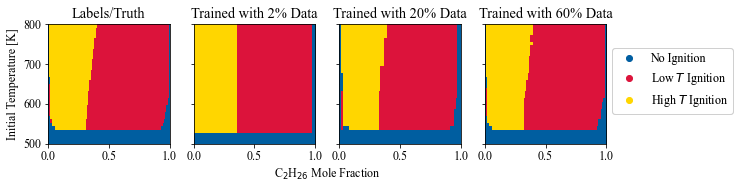

In [84]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2.2), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"C$_2$H$_{26}$ Mole Fraction")
axs[0].set_ylabel("Initial Temperature [K]")

#Plot figurex
axs[0].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
for i in range(len(X_train_list)):
    axs[i+1].imshow(np.flipud(np.array(y_dt_decision_boundary_list[i]).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
axs[0].set_title("Labels/Truth")
axs[1].set_title("Trained with 2% Data")
axs[2].set_title("Trained with 20% Data")
axs[3].set_title("Trained with 60% Data")

my_scatter = axs[3].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[3].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),
                    loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[3].add_artist(legend1)

### 3.4 Visualize Decision Boundaries: SVC

In [85]:
#train and test svc
svc_list = []
y_svc_decision_boundary_list = []
y_svc_test_list = []
y_svc_train_list = []

for i in range(len(X_train_list)):
    svc_list.append(SVC(gamma=0.1, C = 1e5, tol = 1e-4, kernel = 'rbf')
                    .fit(X_train_list[i], y_train_list[i]))
    y_svc_decision_boundary_list.append(svc_list[i].predict(X_decision_boundary))
    y_svc_test_list.append(svc_list[i].predict(X_test_scaled))
    y_svc_train_list.append(svc_list[i].predict(X_train_list[i]))

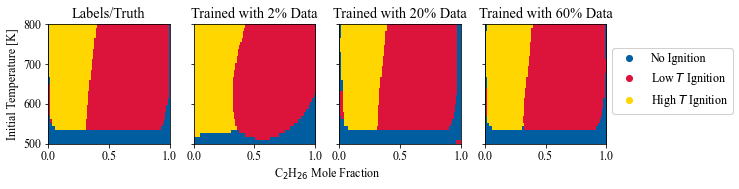

In [92]:
%matplotlib inline 
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
fig, axs = plt.subplots(1, 4, figsize=(10, 2.2), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"C$_2$H$_{26}$ Mole Fraction")
axs[0].set_ylabel("Initial Temperature [K]")

#Plot figure
axs[0].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
for i in range(len(X_train_list)):
    axs[i+1].imshow(np.flipud(np.array(y_svc_decision_boundary_list[i]).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
 
axs[0].set_title("Labels/Truth")
axs[1].set_title("Trained with 2% Data")
axs[2].set_title("Trained with 20% Data")
axs[3].set_title("Trained with 60% Data")

my_scatter = axs[3].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[3].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),
                    loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[3].add_artist(legend1)    

### 3.4 Visualize Decision Boundaries: Random Forest

In [87]:
#train and test rf
rf_list = []
y_rf_decision_boundary_list = []
y_rf_test_list = []
y_rf_train_list = []

for i in range(len(X_train_list)):
    rf_list.append(RandomForestClassifier(random_state=seed,
    n_estimators = 20,
    criterion = 'entropy').fit(X_train_list[i], y_train_list[i]))
    y_rf_decision_boundary_list.append(rf_list[i].predict(X_decision_boundary))
    y_rf_test_list.append(rf_list[i].predict(X_test_scaled))
    y_rf_train_list.append(rf_list[i].predict(X_train_list[i]))

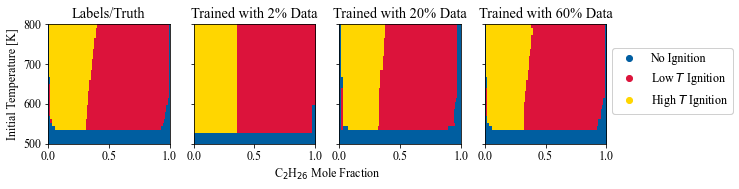

In [93]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2.2), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"C$_2$H$_{26}$ Mole Fraction")
axs[0].set_ylabel("Initial Temperature [K]")

axs[0].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
for i in range(len(X_train_list)):
    axs[i+1].imshow(np.flipud(np.array(y_rf_decision_boundary_list[i]).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)

axs[0].set_title("Labels/Truth")
axs[1].set_title("Trained with 2% Data")
axs[2].set_title("Trained with 20% Data")
axs[3].set_title("Trained with 60% Data")

my_scatter = axs[3].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[3].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),
                    loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[3].add_artist(legend1)    

### 3.4 Visualize Decision Boundaries: Neural Networks

In [94]:
nn_list = []
y_nn_decision_boundary_list = []
y_nn_test_list = []
y_nn_train_list = []

for i in range(len(X_train_list)):
    nn_list.append(MLPClassifier(activation='relu', 
                                    solver='adam', 
                                    max_iter=1000, 
                                    shuffle=True, 
                                    random_state=seed, 
                                    tol=0.0001, 
                                    n_iter_no_change=10
                              ,hidden_layer_sizes=(10,10)
                              ,learning_rate_init=1e-3
                              ,epsilon = 1e-7
                              ,beta_2= 0.995
                              ,beta_1= 0.99
                              ,batch_size= 20
                              ,alpha= 1e-05).fit(X_train_list[i], y_train_list[i]))
    y_nn_decision_boundary_list.append(nn_list[i].predict(X_decision_boundary))
    y_nn_test_list.append(nn_list[i].predict(X_test_scaled))
    y_nn_train_list.append(nn_list[i].predict(X_train_list[i]))

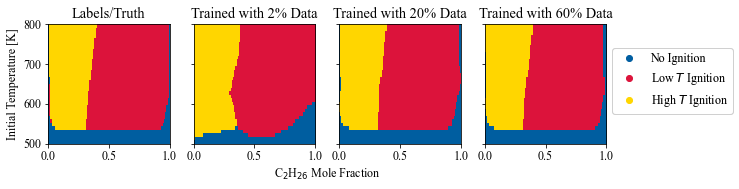

In [95]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2.2), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"C$_2$H$_{26}$ Mole Fraction")
axs[0].set_ylabel("Initial Temperature [K]")

axs[0].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
for i in range(len(X_train_list)):
    axs[i+1].imshow(np.flipud(np.array(y_nn_decision_boundary_list[i]).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
    
axs[0].set_title("Labels/Truth")
axs[1].set_title("Trained with 2% Data")
axs[2].set_title("Trained with 20% Data")
axs[3].set_title("Trained with 60% Data")

my_scatter = axs[3].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[3].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),
                    loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[3].add_artist(legend1)    

### 3.4 Visualize Decision Boundaries: Putting it together

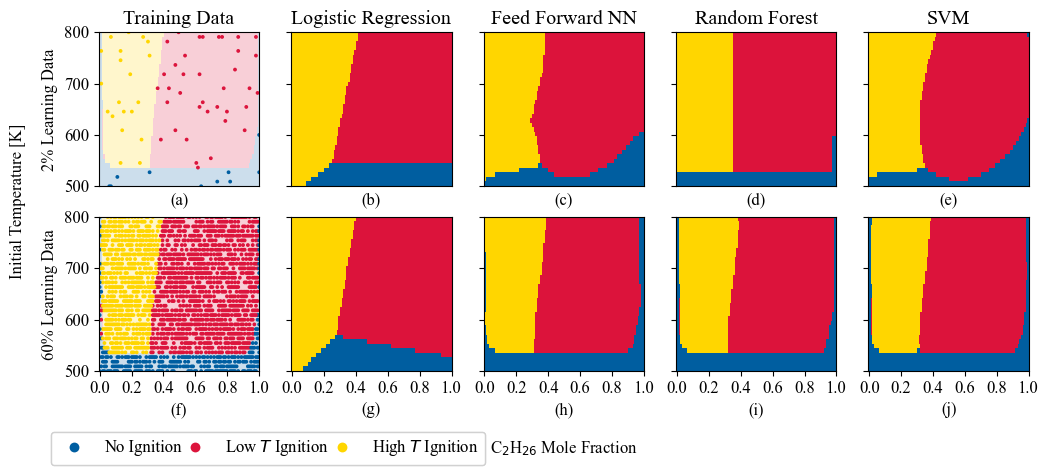

In [534]:
fig, axs = plt.subplots(2, 5, figsize=(12, 4.4), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("\n\nC$_2$H$_{26}$ Mole Fraction")
plt.ylabel("Initial Temperature [K]\n\n")
axs[0,0].set_ylabel("2% Learning Data")
axs[1,0].set_ylabel("60% Learning Data")

#Training data
axs[0,0].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'nearest',cmap = cmap,alpha=0.2)
axs[0,0].set_title('Training Data')
axs[0,0].set_xlabel('(a)')
my_scatter = axs[0,0].scatter(X_train2.X_fu,X_train2.T_0,c=y_train2,cmap=cmap,marker='.',s=12)
legend1 = axs[1,0].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),
                    loc=(-0.3,-0.61),ncol = 3,columnspacing=-0.2)
axs[1,0].add_artist(legend1)

axs[0,1].imshow(np.flipud(np.array(y_logReg_decision_boundary_list[0]).reshape(34,100)),extent=[0,1,500,800]
       ,aspect='auto',interpolation = 'nearest',cmap = cmap)
axs[0,1].set_xlabel('(b)')
axs[0,1].set_title('Logistic Regression')
axs[0,2].imshow(np.flipud(np.array(y_nn_decision_boundary_list[0]).reshape(34,100)),extent=[0,1,500,800]
       ,aspect='auto',interpolation = 'nearest',cmap = cmap)
axs[0,2].set_xlabel('(c)')
axs[0,2].set_title('Feed Forward NN')
axs[0,3].imshow(np.flipud(np.array(y_rf_decision_boundary_list[0]).reshape(34,100)),extent=[0,1,500,800]
       ,aspect='auto',interpolation = 'nearest',cmap = cmap)
axs[0,3].set_xlabel('(d)')
axs[0,3].set_title('Random Forest')
axs[0,4].imshow(np.flipud(np.array(y_svc_decision_boundary_list[0]).reshape(34,100)),extent=[0,1,500,800]
       ,aspect='auto',interpolation = 'nearest',cmap = cmap)
axs[0,4].set_xlabel('(e)')
axs[0,4].set_title('SVM')

axs[1,0].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'nearest',cmap = cmap,alpha=0.2)
axs[1,0].set_xlabel('(f)')
axs[1,0].scatter(X_train.X_fu,X_train.T_0,c=y_train,cmap=cmap,marker='.',s=12)
axs[1,1].imshow(np.flipud(np.array(y_logReg_decision_boundary_list[2]).reshape(34,100)),extent=[0,1,500,800]
       ,aspect='auto',interpolation = 'nearest',cmap = cmap)
axs[1,1].set_xlabel('(g)')
axs[1,2].imshow(np.flipud(np.array(y_nn_decision_boundary_list[2]).reshape(34,100)),extent=[0,1,500,800]
       ,aspect='auto',interpolation = 'nearest',cmap = cmap)
axs[1,2].set_xlabel('(h)')
axs[1,3].imshow(np.flipud(np.array(y_rf_decision_boundary_list[2]).reshape(34,100)),extent=[0,1,500,800]
       ,aspect='auto',interpolation = 'nearest',cmap = cmap)
axs[1,3].set_xlabel('(i)')
axs[1,4].imshow(np.flipud(np.array(y_svc_decision_boundary_list[2]).reshape(34,100)),extent=[0,1,500,800]
       ,aspect='auto',interpolation = 'nearest',cmap = cmap)
axs[1,4].set_xlabel('(j)')


for j in range(len(axs[0])):
    for i in range(len(axs)):
        axs[i,j].set_xlim([-0.005,1.0])
    axs[0,j].set_xticks([])
    axs[1,j].set_xticks([0,0.2,0.4,0.6,0.8,1])
        
fig.savefig("./figs/clf_decision_boundary.pdf", bbox_inches="tight")

All nonlinear classifiers(c,d,e) perform well when trained with 60% learning data, but demonstrate some flaws when trained with 2% learning data. For example, the sharp boundaries predicted by the random forest, in contrast to the smooth boundaries produced by SVMs and neural networks, are artefacts of recursively partitioning the feature space during training. In many applications, decision trees and random forests can face issues when extrapolating outside of the training set due to this recursive partitioning; partitions for labels outside the training set are not well defined, which can result in clipped predictions. Logistic regression do not perform well with nonlinear problems without some sort of nonlinear transformation.